In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

2022-11-28 11:03:41.038865: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# fix random seed for reproducibility
tf.random.set_seed(7)

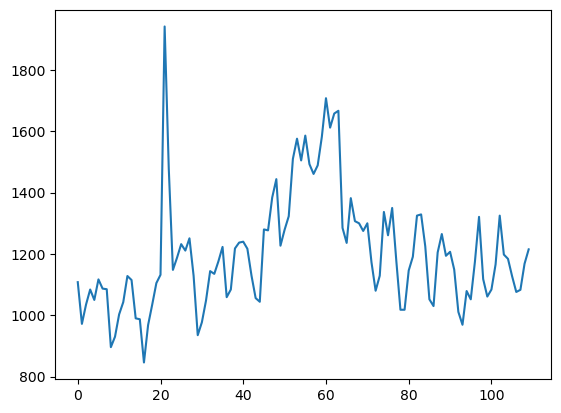

In [3]:
# Use a random dataset for testing
import pandas as pd
import matplotlib.pyplot as plt
dataframe = pd.read_csv('timeseries2.csv', usecols=[2], engine='python')
plt.plot(dataframe)
plt.show()

In [4]:
# Change the dataset format to float
dataset = dataframe.values
dataset = dataset.astype('float32')

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [5]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

73 37


In [6]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [7]:
# reshape into X=t and Y=t+1
look_back = 10
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# print(trainX)

# for i in range(trainX.shape[0]):
#     print(i, trainX[i, 0], trainY[i])

In [8]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [9]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

2022-11-28 11:03:55.730046: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-28 11:03:55.730688: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/100
62/62 - 2s - loss: 0.1578 - 2s/epoch - 34ms/step
Epoch 2/100
62/62 - 0s - loss: 0.0796 - 214ms/epoch - 3ms/step
Epoch 3/100
62/62 - 0s - loss: 0.0385 - 311ms/epoch - 5ms/step
Epoch 4/100
62/62 - 0s - loss: 0.0270 - 257ms/epoch - 4ms/step
Epoch 5/100
62/62 - 0s - loss: 0.0255 - 271ms/epoch - 4ms/step
Epoch 6/100
62/62 - 0s - loss: 0.0252 - 209ms/epoch - 3ms/step
Epoch 7/100
62/62 - 0s - loss: 0.0247 - 204ms/epoch - 3ms/step
Epoch 8/100
62/62 - 0s - loss: 0.0248 - 342ms/epoch - 6ms/step
Epoch 9/100
62/62 - 0s - loss: 0.0240 - 231ms/epoch - 4ms/step
Epoch 10/100
62/62 - 0s - loss: 0.0239 - 188ms/epoch - 3ms/step
Epoch 11/100
62/62 - 0s - loss: 0.0235 - 209ms/epoch - 3ms/step
Epoch 12/100
62/62 - 0s - loss: 0.0232 - 262ms/epoch - 4ms/step
Epoch 13/100
62/62 - 0s - loss: 0.0227 - 339ms/epoch - 5ms/step
Epoch 14/100
62/62 - 0s - loss: 0.0224 - 247ms/epoch - 4ms/step
Epoch 15/100
62/62 - 0s - loss: 0.0221 - 302ms/epoch - 5ms/step
Epoch 16/100
62/62 - 0s - loss: 0.0221 - 356ms/epoc

In [10]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

1/1 [==============================] - 0s 25ms/step
Train Score: 139.51 RMSE
Test Score: 88.27 RMSE


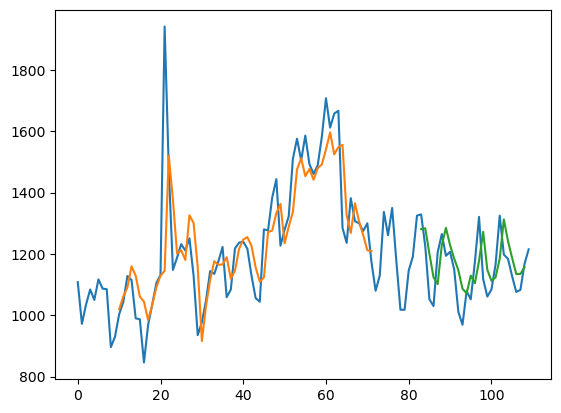

In [11]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()